# Import Needed Libs and Load data

In [1]:
import nltk
import re
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import emoji
import matplotlib.pyplot as plt
from nltk.util import ngrams
import matplotlib
import contractions
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [2]:
data = pd.read_csv("../data/raw/mbti_1.csv")
df = pd.read_csv("../data/raw/mbti_1.csv")
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


# Data Preprocessing

In [3]:
data.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [4]:
data.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [5]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r'https?\S+|www\S+', '', text)

  text = emoji.replace_emoji(text, replace='')

  text = re.sub(r'@\w+|#', '', text)


  text=re.sub('[^a-z\']',' ',text)

  text = re.sub(r'\b(I|E)(N|S)(F|T)(J|P)\b', '', text, flags=re.IGNORECASE)

  text = re.sub(r'\bsent from my \w+ using tapatalk\b', '', text)
  text = re.sub(r'\bsent my \w+ using tapatalk\b', '', text)
  text = re.sub(r'\bsent my \w+ \w+ using tapatalk\b', '', text)
  
  text = re.sub(r'\s+', ' ', text)

  text = re.sub(r'w w w', '', text)
  
  text = text.strip()

  return text

In [6]:
def preprocess_posts(posts_str):
    posts = posts_str.split('|||')
    cleaned_posts = [clean_text(post) for post in posts]
    joined = ' '.join(cleaned_posts)
    joined = re.sub(r'\s+', ' ', joined).strip()
    return joined



In [7]:
df['cleaned_posts'] = df['posts']
for i in tqdm(range(len(df))):
    df.cleaned_posts[i] = preprocess_posts(df.posts[i])
    df.cleaned_posts[i] = df.cleaned_posts[i][1:-1]

100%|██████████| 8675/8675 [01:04<00:00, 135.18it/s]


In [8]:
df.cleaned_posts[0]

" and moments sportscenter not top ten plays pranks what has been the most life changing experience in your life on repeat for most of today may the perc experience immerse you the last thing my friend posted on his facebook before committing suicide the next day rest in peace hello sorry to hear of your distress it's only natural for a relationship to not be perfection all the time in every moment of existence try to figure the hard times as times of growth as welcome and stuff game set match prozac wellbrutin at least thirty minutes of moving your legs and i don't mean moving them while sitting in your same desk chair weed in moderation maybe try edibles as a healthier alternative basically come up with three items you've determined that each type or whichever types you want to do would more than likely use given each types' cognitive functions and whatnot when left by all things in moderation sims is indeed a video game and a good one at that note a good one at that is somewhat subj

In [9]:
def encode_mbti_type(mbti):
    """
    Converts 'INFJ' → [1, 0, 1, 1] for [I/E, N/S, F/T, J/P]
    I=1, E=0; N=1, S=0; F=1, T=0; J=1, P=0
    """
    return [
        1 if mbti[0] == 'I' else 0,
        1 if mbti[1] == 'N' else 0,
        1 if mbti[2] == 'F' else 0,
        1 if mbti[3] == 'J' else 0
    ]


In [10]:

df[['IE', 'NS', 'FT', 'JP']] = pd.DataFrame(df['type'].apply(encode_mbti_type).tolist())

In [11]:
df.head()

,type,posts,cleaned_posts,IE,NS,FT,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top ten plays pr...,1,1,1,1
1,ENTP,'I'm finding the lack of me in these posts ver...,i'm finding the lack of me in these posts very...,0,1,0,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one of course to which i say i know that'...,1,1,0,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear i enjoyed our conversation the other day ...,1,1,0,1
4,ENTJ,'You're fired.|||That's another silly misconce...,you're fired that's another silly misconceptio...,0,1,0,1


_______________

In [12]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:  
        return wordnet.NOUN


def tokenize_text(text):
    wnl = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    fixed = contractions.fix(text)
    tokens = word_tokenize(fixed)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    pos_tags = nltk.pos_tag(filtered_tokens)
    
    lemmatizedTokens = [wnl.lemmatize(t, pos=get_wordnet_pos(p)) for t, p in pos_tags]
    return lemmatizedTokens

tqdm.pandas()

print("Tokenizing cleaned posts...")
df['tokens'] = df['cleaned_posts'].progress_apply(tokenize_text)

print("\nOriginal cleaned text:")
print(df['cleaned_posts'].iloc[0][:200] + "...")
print("\nTokenized version:")
print(df['tokens'].iloc[0][:20]) 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Tokenizing cleaned posts...


100%|██████████| 8675/8675 [04:34<00:00, 31.60it/s]


Original cleaned text:
 and moments sportscenter not top ten plays pranks what has been the most life changing experience in your life on repeat for most of today may the perc experience immerse you the last thing my friend...

Tokenized version:
['moment', 'sportscenter', 'top', 'ten', 'play', 'pranks', 'life', 'change', 'experience', 'life', 'repeat', 'today', 'may', 'perc', 'experience', 'immerse', 'last', 'thing', 'friend', 'post']


In [13]:
def Generate_grams(tokens):
  Unigrams = list(ngrams(tokens,1))
  Bigrams = list(ngrams(tokens,2))
  Trigrams = list(ngrams(tokens,3))
  return Unigrams, Bigrams, Trigrams

In [14]:
df[['Unigrams', 'Bigrams', 'Trigrams']] = pd.DataFrame(df['tokens'].progress_apply(Generate_grams).tolist(),)

100%|██████████| 8675/8675 [00:02<00:00, 4296.56it/s]


In [15]:
df.head()

,type,posts,cleaned_posts,IE,NS,FT,JP,tokens,Unigrams,Bigrams,Trigrams
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top ten plays pr...,1,1,1,1,"[moment, sportscenter, top, ten, play, pranks,...","[(moment,), (sportscenter,), (top,), (ten,), (...","[(moment, sportscenter), (sportscenter, top), ...","[(moment, sportscenter, top), (sportscenter, t..."
1,ENTP,'I'm finding the lack of me in these posts ver...,i'm finding the lack of me in these posts very...,0,1,0,0,"[find, lack, post, alarm, sex, boring, positio...","[(find,), (lack,), (post,), (alarm,), (sex,), ...","[(find, lack), (lack, post), (post, alarm), (a...","[(find, lack, post), (lack, post, alarm), (pos..."
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one of course to which i say i know that'...,1,1,0,0,"[good, one, course, say, know, bless, curse, a...","[(good,), (one,), (course,), (say,), (know,), ...","[(good, one), (one, course), (course, say), (s...","[(good, one, course), (one, course, say), (cou..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear i enjoyed our conversation the other day ...,1,1,0,1,"[dear, enjoyed, conversation, day, esoteric, g...","[(dear,), (enjoyed,), (conversation,), (day,),...","[(dear, enjoyed), (enjoyed, conversation), (co...","[(dear, enjoyed, conversation), (enjoyed, conv..."
4,ENTJ,'You're fired.|||That's another silly misconce...,you're fired that's another silly misconceptio...,0,1,0,1,"[fire, another, silly, misconception, approach...","[(fire,), (another,), (silly,), (misconception...","[(fire, another), (another, silly), (silly, mi...","[(fire, another, silly), (another, silly, misc..."


Top Unigrams by Personality Type:


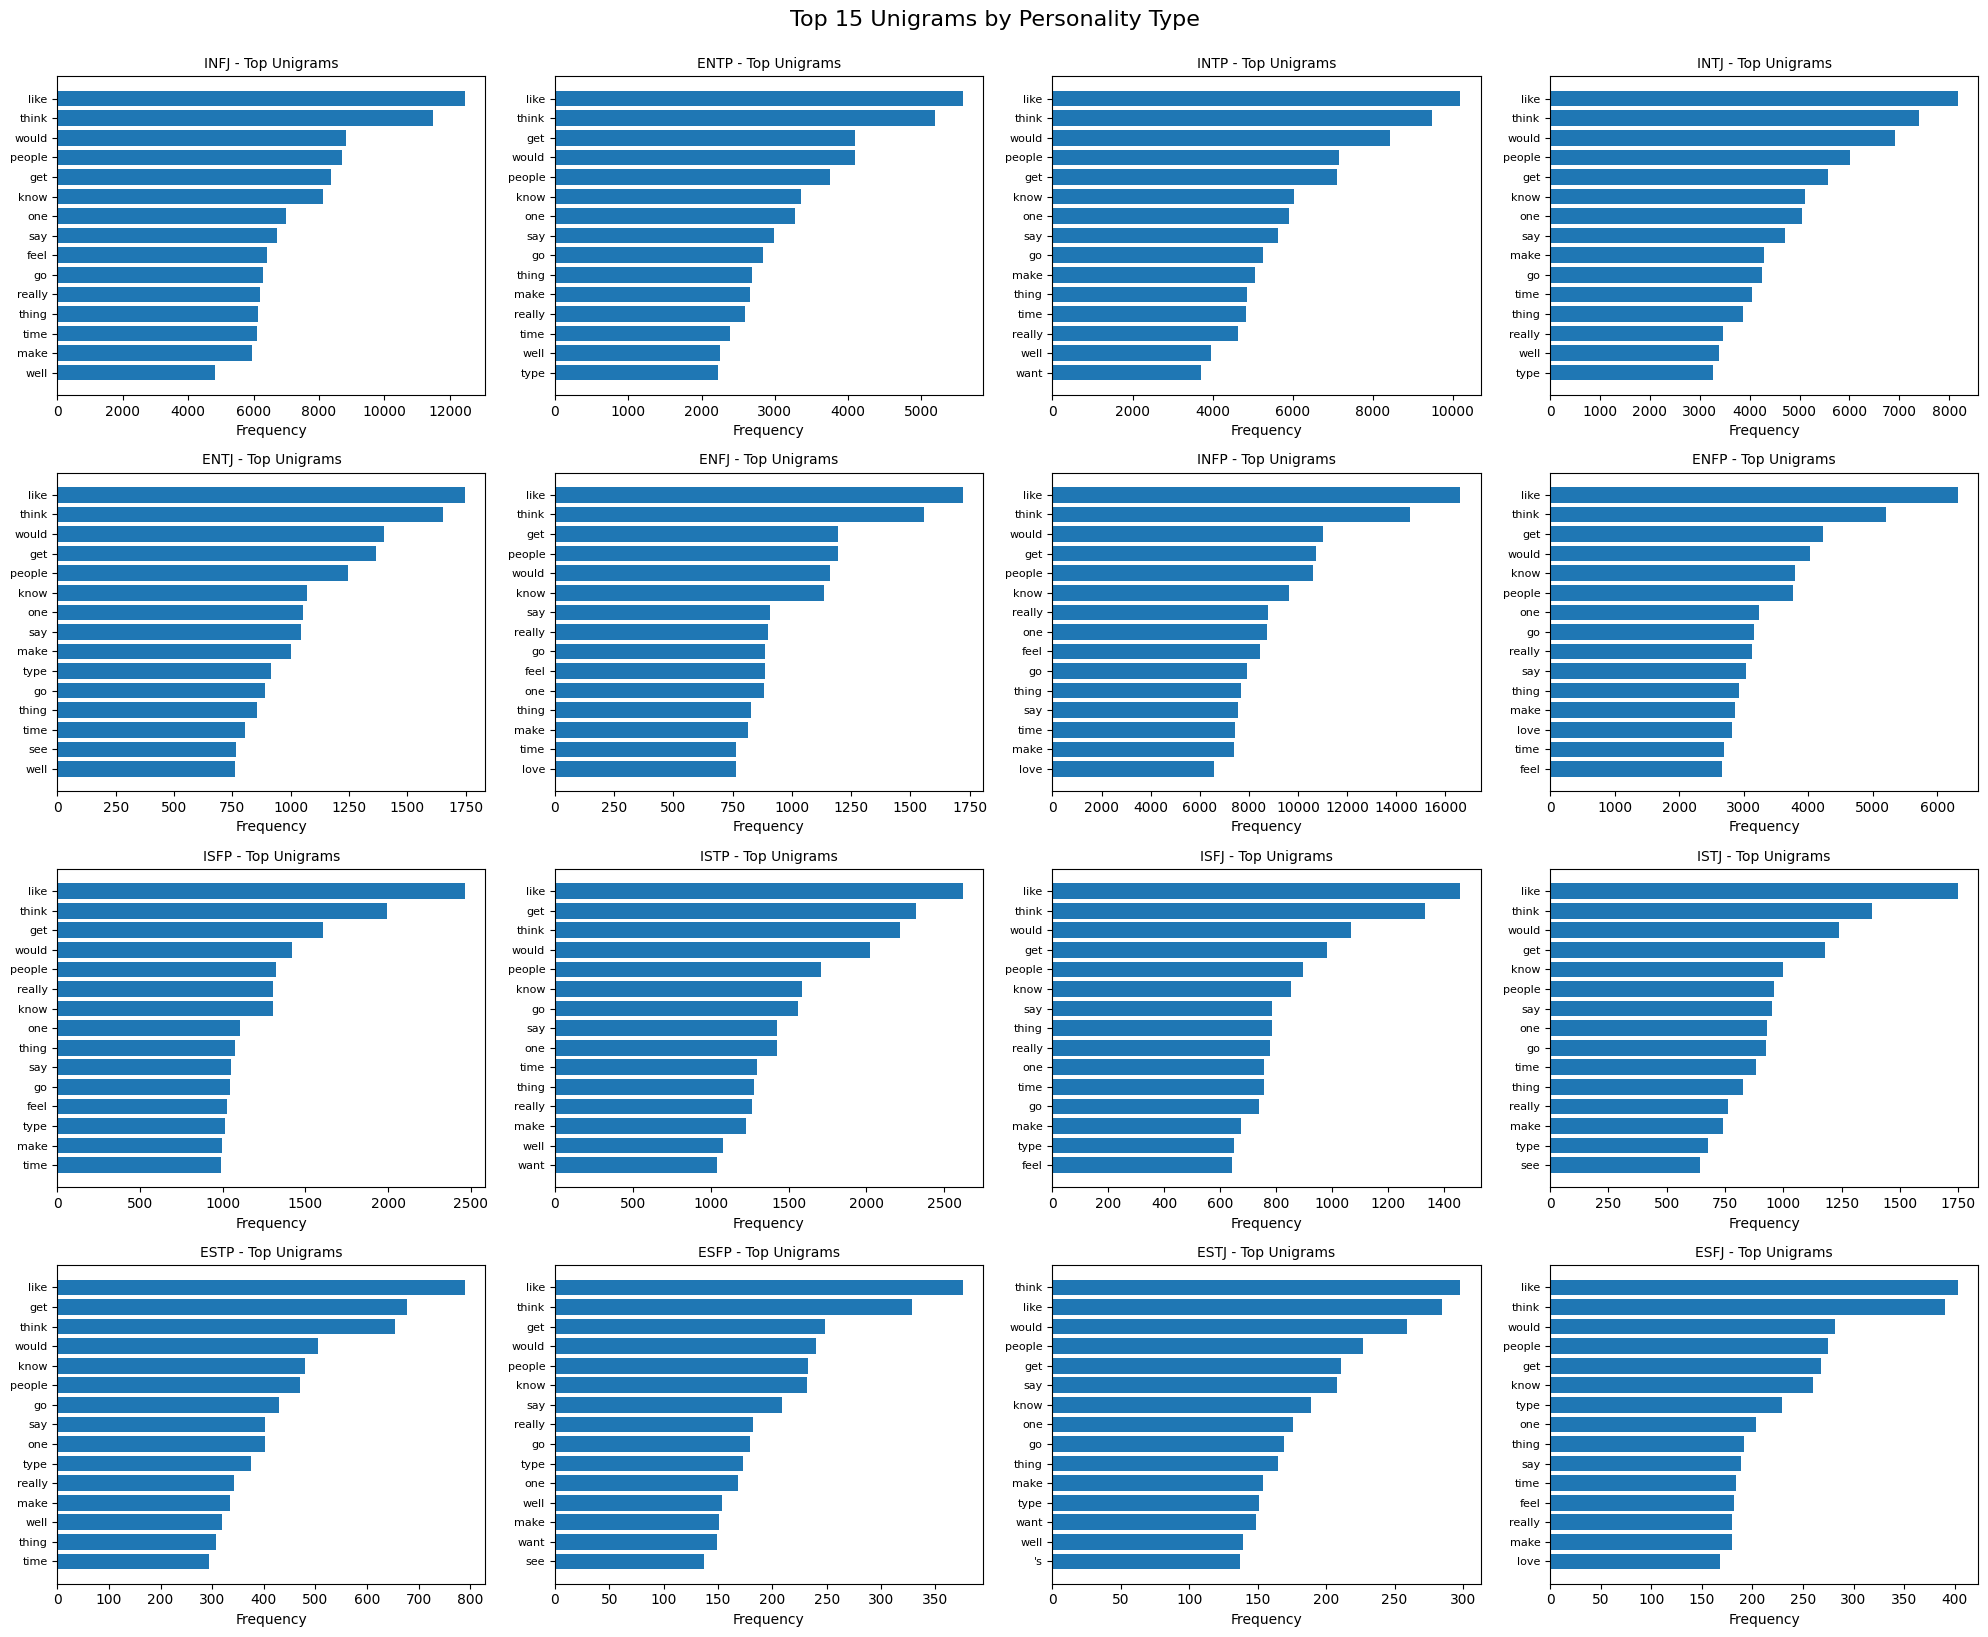


Top Bigrams by Personality Type:


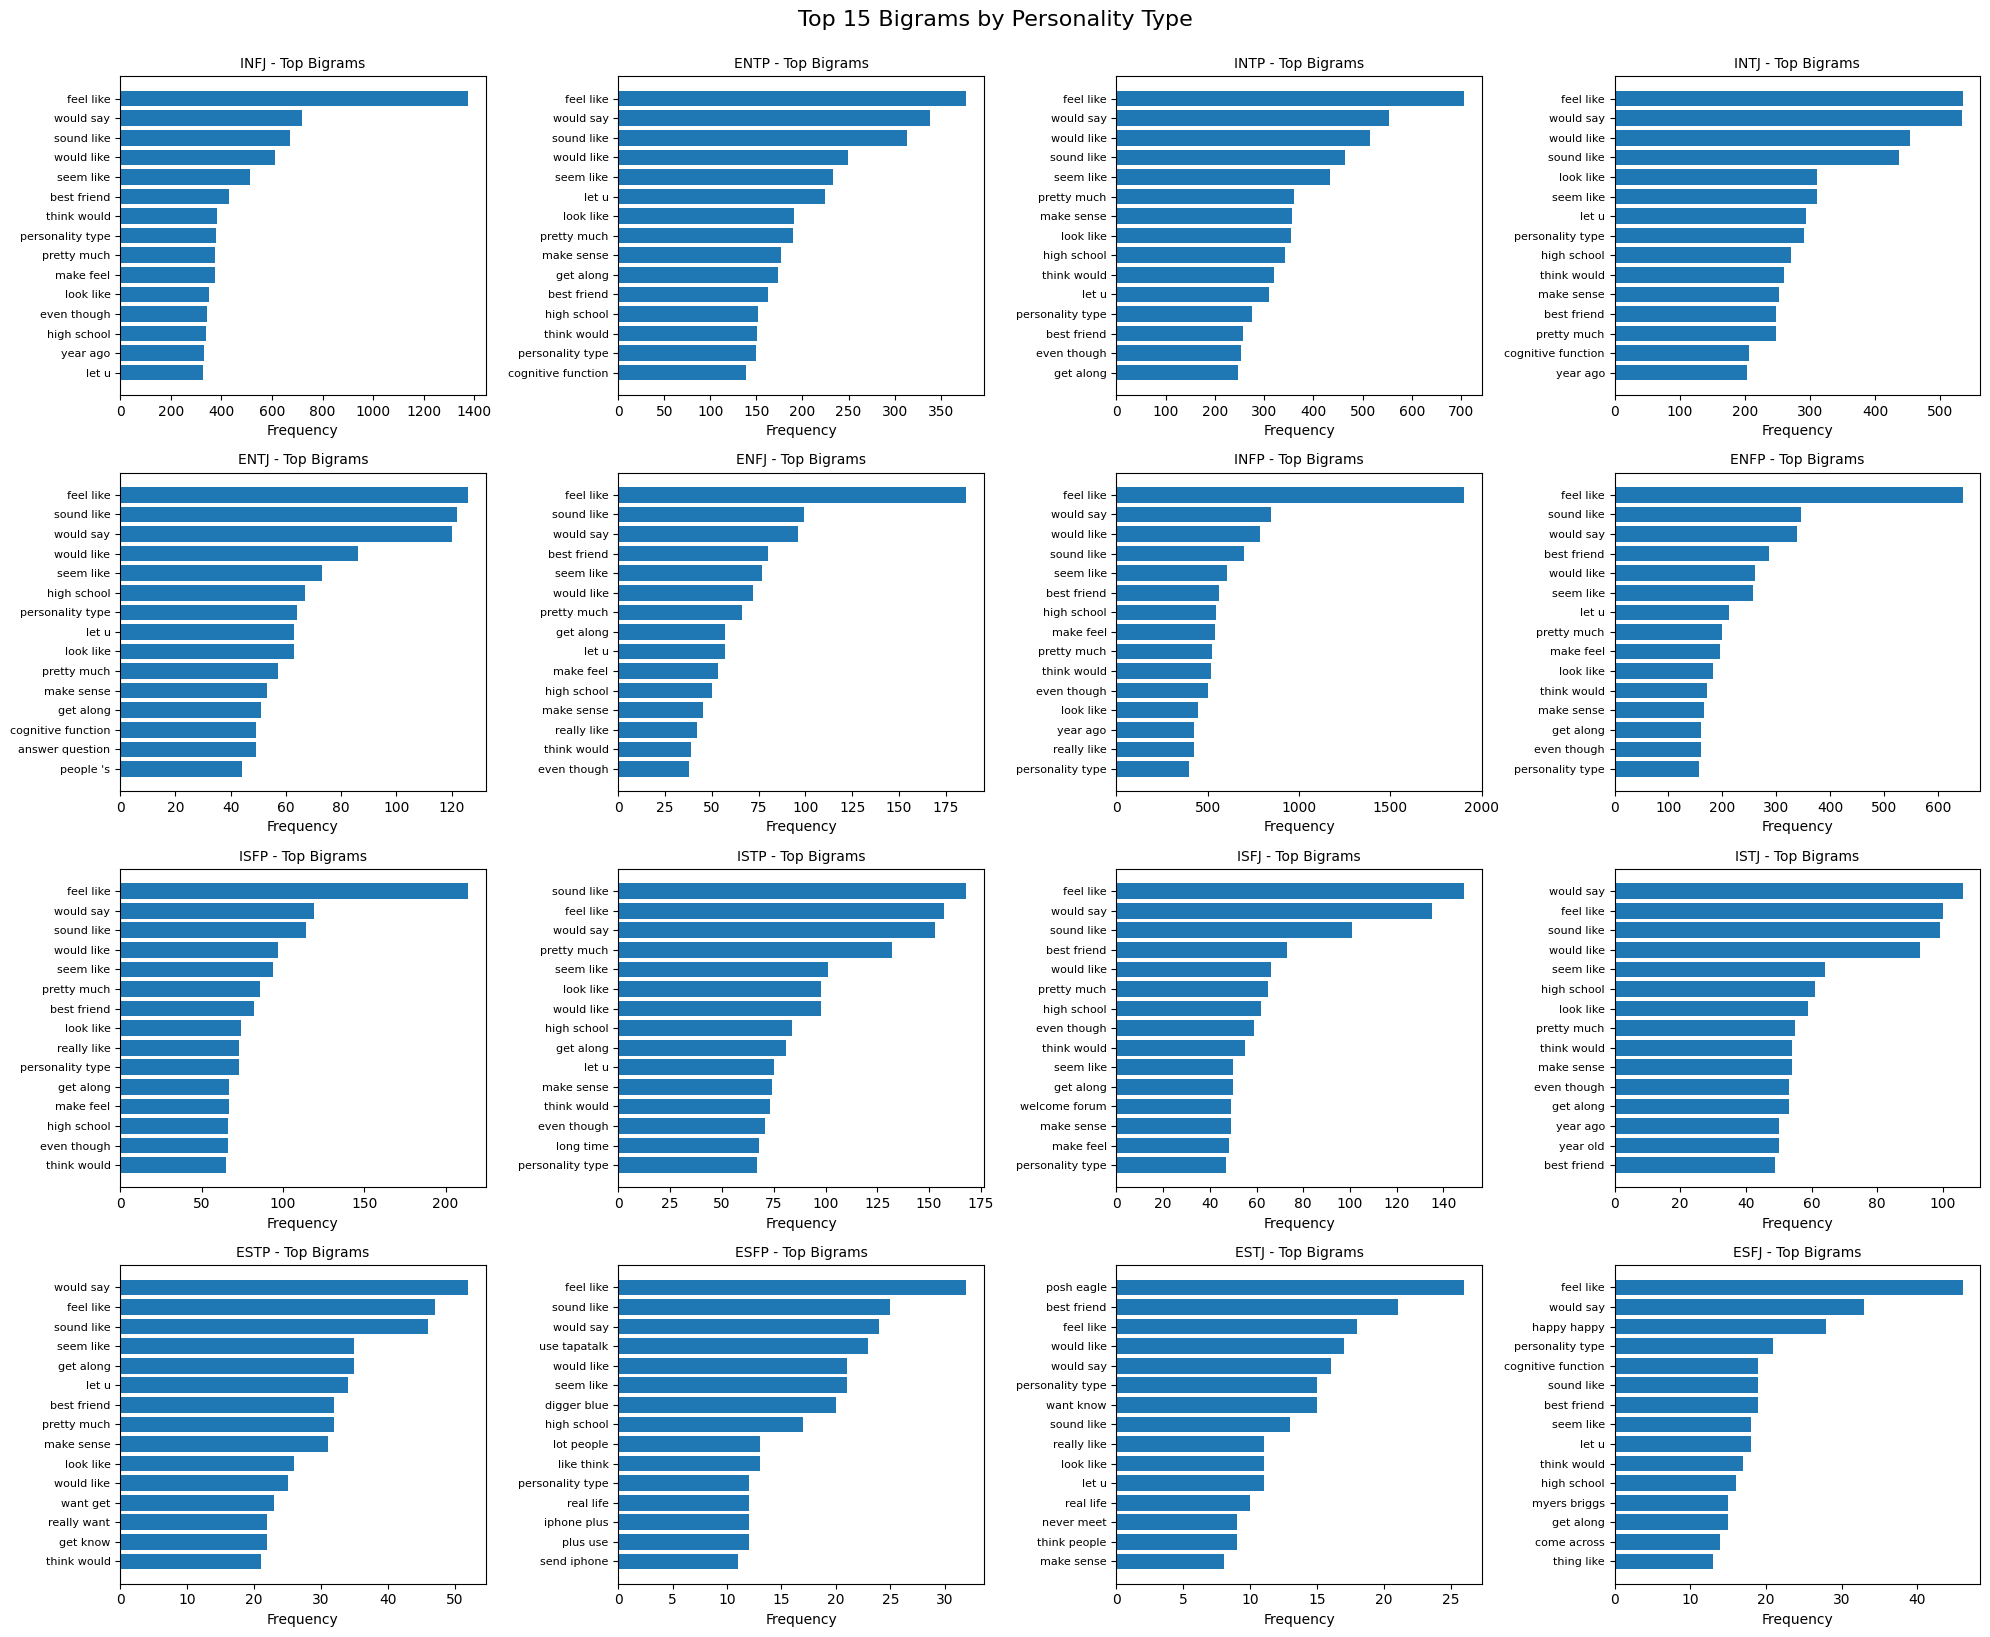


Top Trigrams by Personality Type:


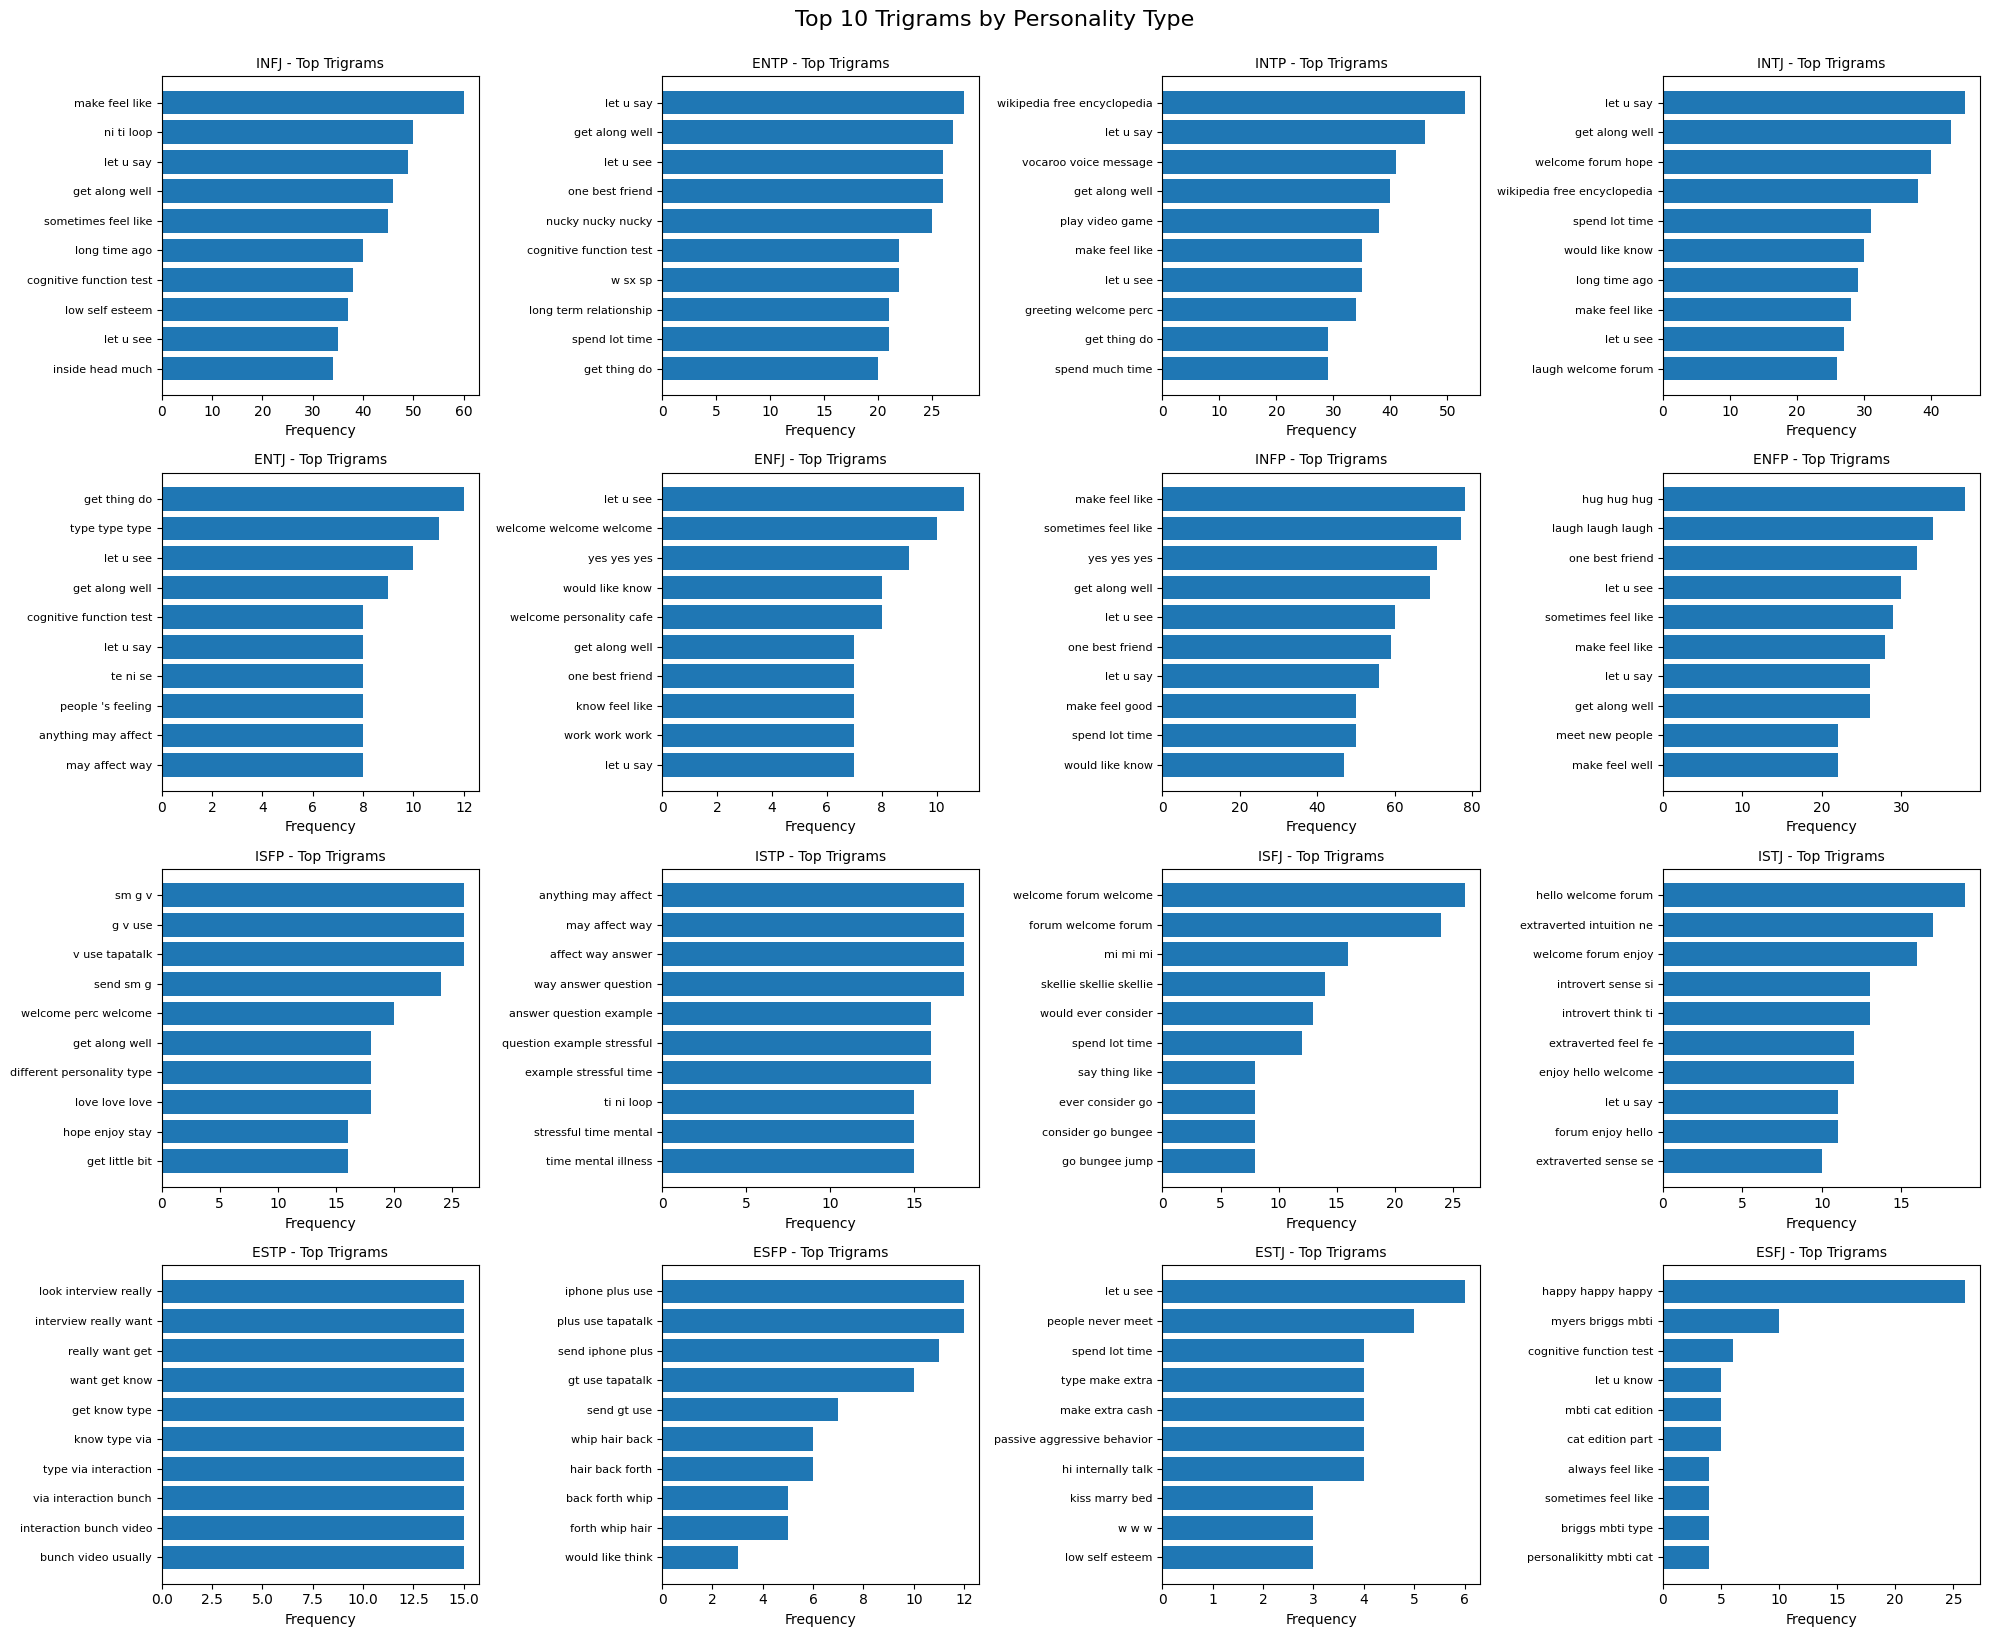

In [16]:
def get_top_ngrams_by_type(ngram_type='unigrams', top_n=20):
    """
    Get top n-grams for each personality type
    ngram_type: 'unigrams', 'bigrams', or 'trigrams'
    """
    personality_types = df['type'].unique()
    
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    axes = axes.flatten()
    
    for idx, personality in enumerate(personality_types):
        # Filter data for this personality type
        type_data = df[df['type'] == personality]
        
        # Collect all n-grams for this type
        all_ngrams = []
        for tokens in type_data['tokens']:
            if ngram_type == 'unigrams':
                ngs = list(ngrams(tokens, 1))
            elif ngram_type == 'bigrams':
                ngs = list(ngrams(tokens, 2))
            elif ngram_type == 'trigrams':
                ngs = list(ngrams(tokens, 3))
            all_ngrams.extend(ngs)
        
        # Count frequencies
        ngram_counts = Counter(all_ngrams)
        top_ngrams = ngram_counts.most_common(top_n)
        
        # Prepare data for plotting
        ngram_texts = [' '.join(gram) for gram, count in top_ngrams]
        counts = [count for gram, count in top_ngrams]
        
        # Create horizontal bar plot
        axes[idx].barh(range(len(ngram_texts)), counts)
        axes[idx].set_yticks(range(len(ngram_texts)))
        axes[idx].set_yticklabels(ngram_texts, fontsize=8)
        axes[idx].set_title(f'{personality} - Top {ngram_type.title()}', fontsize=10)
        axes[idx].set_xlabel('Frequency')
        
        # Invert y-axis to have highest frequency at top
        axes[idx].invert_yaxis()
    
    plt.tight_layout()
    plt.suptitle(f'Top {top_n} {ngram_type.title()} by Personality Type', 
                 fontsize=16, y=1.02)
    plt.show()


print("Top Unigrams by Personality Type:")
get_top_ngrams_by_type('unigrams', 15)

print("\nTop Bigrams by Personality Type:")
get_top_ngrams_by_type('bigrams', 15)

print("\nTop Trigrams by Personality Type:")
get_top_ngrams_by_type('trigrams', 10)

In [17]:
df.head()

,type,posts,cleaned_posts,IE,NS,FT,JP,tokens,Unigrams,Bigrams,Trigrams
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top ten plays pr...,1,1,1,1,"[moment, sportscenter, top, ten, play, pranks,...","[(moment,), (sportscenter,), (top,), (ten,), (...","[(moment, sportscenter), (sportscenter, top), ...","[(moment, sportscenter, top), (sportscenter, t..."
1,ENTP,'I'm finding the lack of me in these posts ver...,i'm finding the lack of me in these posts very...,0,1,0,0,"[find, lack, post, alarm, sex, boring, positio...","[(find,), (lack,), (post,), (alarm,), (sex,), ...","[(find, lack), (lack, post), (post, alarm), (a...","[(find, lack, post), (lack, post, alarm), (pos..."
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one of course to which i say i know that'...,1,1,0,0,"[good, one, course, say, know, bless, curse, a...","[(good,), (one,), (course,), (say,), (know,), ...","[(good, one), (one, course), (course, say), (s...","[(good, one, course), (one, course, say), (cou..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear i enjoyed our conversation the other day ...,1,1,0,1,"[dear, enjoyed, conversation, day, esoteric, g...","[(dear,), (enjoyed,), (conversation,), (day,),...","[(dear, enjoyed), (enjoyed, conversation), (co...","[(dear, enjoyed, conversation), (enjoyed, conv..."
4,ENTJ,'You're fired.|||That's another silly misconce...,you're fired that's another silly misconceptio...,0,1,0,1,"[fire, another, silly, misconception, approach...","[(fire,), (another,), (silly,), (misconception...","[(fire, another), (another, silly), (silly, mi...","[(fire, another, silly), (another, silly, misc..."


MBTI Type Distribution:
 type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64
Dichotomy Percentages:
          I/E        N/S       F/T        J/P
0  23.043228  13.798271  45.89049  60.414986
1  76.956772  86.201729  54.10951  39.585014


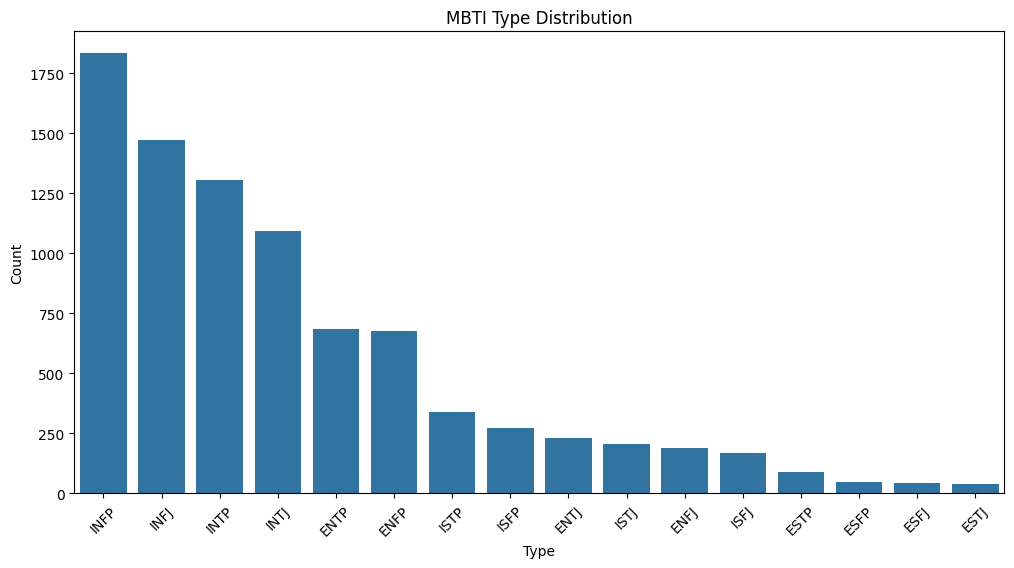

In [18]:


def analyze_class_distribution(df: pd.DataFrame):
    """
    Compute and plot class distribution for MBTI types and dichotomies.
    """
    # 16 types
    type_counts = df['type'].value_counts()
    print("MBTI Type Distribution:\n", type_counts)
    
    # Dichotomies (using binary encodings)
    dichotomy_counts = {
        'I/E': df['IE'].value_counts(normalize=True) * 100,  # 1=I, 0=E
        'N/S': df['NS'].value_counts(normalize=True) * 100,  # 1=N, 0=S
        'F/T': df['FT'].value_counts(normalize=True) * 100,  # 1=F, 0=T
        'J/P': df['JP'].value_counts(normalize=True) * 100,  # 1=J, 0=P
    }
    print("Dichotomy Percentages:\n", pd.DataFrame(dichotomy_counts))
    
    # Plot 16 types
    plt.figure(figsize=(12, 6))
    sns.barplot(x=type_counts.index, y=type_counts.values)
    plt.title('MBTI Type Distribution')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

analyze_class_distribution(df)

In [19]:

def split_data(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    """
    Split into train/test, stratified by 'type'.
    Returns X_train, X_test, y_train, y_test (y as binary dichotomies).
    """
    # Features: Use 'cleaned_posts' for text-based models
    X = df['cleaned_posts']
    y = df[['IE', 'NS', 'FT', 'JP']]  # Binary multi-label targets
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=df['type']
    )
    return X_train, X_test, y_train, y_test

# Perform split
X_train, X_test, y_train, y_test = split_data(df)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 6940, Test size: 1735
